## BOOK RECOMMENDER SYSTEM BASED ON SUMMARY

My team won BrainStation 3D Hackathon in partnership with EY with project BookHero, an app that helps drive revenue for bookstores by increasing customer engagement.<br>
I had a chance to work with Web Development Team, UX and EY team. It was a great experience.<br> 
Data Science team, my teammate - Louell Uy defined the problem that in-store book sales have recently been decreasing and have been hit especially hard by COVID-19. And I have built a book recommender system.<br>
My question was how to bring the results to the front-end. That's why I want to try to build a simple web app in this project to give book recommendations to users.<br>

Here is the workflow:
1. Read data from txt file
2. Normalize summary (remove special character, stop word... in summary)
3. Extract TF-IDF Features
4. Generate cosine similarity
5. Extract data from cosine similarity to use in web app (due to memory issue in flask app, only first 5000 rows was extracted)

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import contractions
from nlppreprocess import NLP
from sklearn.metrics.pairwise import linear_kernel      #faster than cosine_similarity
import missingno as msno
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size

### 1. Read data from txt file

In [2]:
book_df = pd.read_csv('booksummaries.txt',error_bad_lines=False,delimiter="\t",header=None,\
                      names=["BookID", "Unknown", "Title","Author","Published Date","Tags","Summary"])
book_df.head()

,BookID,Unknown,Title,Author,Published Date,Tags,Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [3]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   BookID          16559 non-null  int64 
 1   Unknown         16559 non-null  object
 2   Title           16559 non-null  object
 3   Author          14177 non-null  object
 4   Published Date  10949 non-null  object
 5   Tags            12841 non-null  object
 6   Summary         16559 non-null  object
dtypes: int64(1), object(6)
memory usage: 905.7+ KB


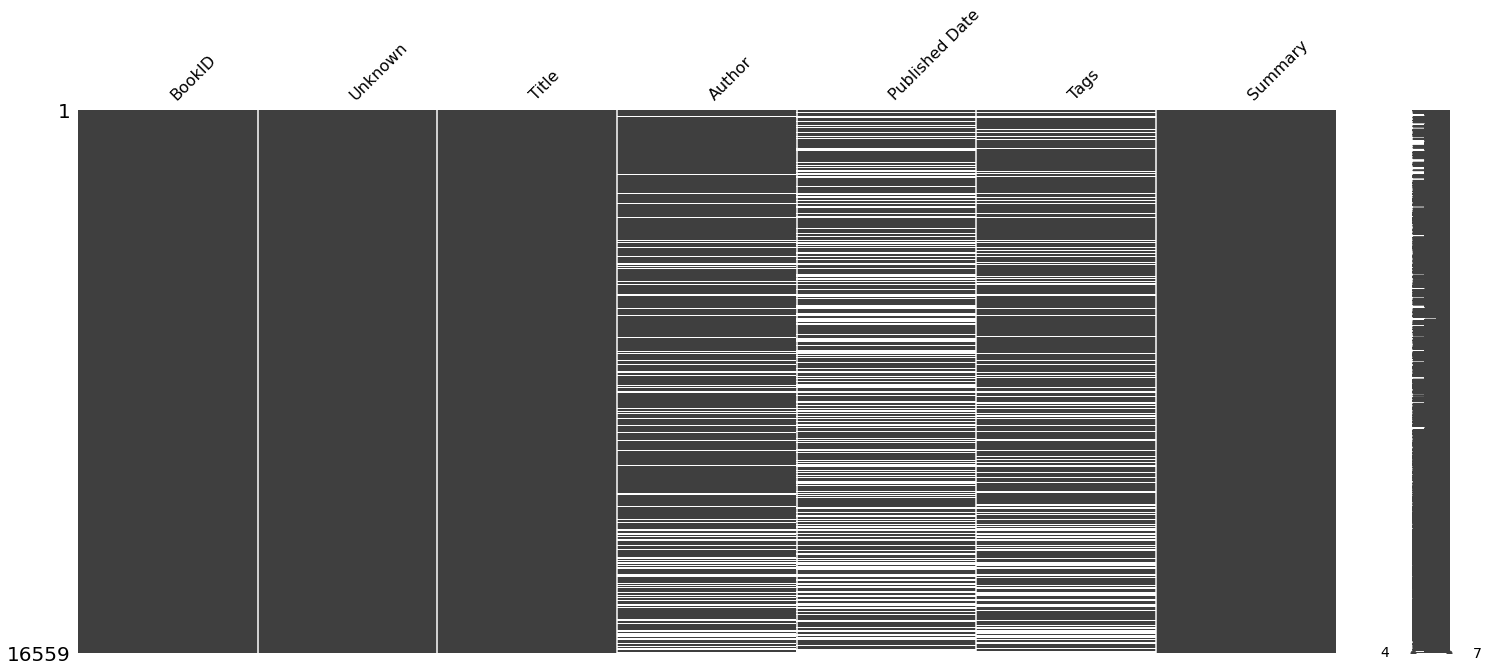

In [4]:
#get missing value matrix
msno.matrix(book_df)

There are many missing value in columns Author, Published Date, Tags but I don't need that data for my book recommender so I will not do any thing with missing values.

In [5]:
#check duplicate on BookID
book_df[['BookID']].duplicated().sum()

0

BookID is unique.<br> It means there is no duplicate in books as each book has a unique ID.

### 2. Normalize summary

In [6]:
#read 1 summary
book_df['Summary'][0]

' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. N

In [7]:
def normalize_sentence(sentence):
    norm_sentence = contractions.fix(sentence) #convert "isn't" to "is not"
    norm_sentence = re.sub(r'[^a-zA-Z\s]', ' ', norm_sentence, re.I|re.A) #only get the words and white space, no special characters nor number
    nlp = NLP()
    norm_sentence = nlp.process(norm_sentence) #remove stop word but still keep "not, no ..."
    norm_sentence = norm_sentence.lower() #conver to lower case
    return norm_sentence

In [8]:
#summary after normalization
normalize_sentence(book_df['Summary'][0])

'old major old boar manor farm calls animals farm meeting where compares humans parasites and teaches animals revolutionary song beasts england when major dies two young pigs snowball and napoleon assume command and turn his dream into philosophy animals revolt and drive drunken and irresponsible mr jones from farm renaming animal farm they adopt seven commandments animal ism most important which animals are equal snowball attempts teach animals reading and writing food plentiful and farm runs smoothly pigs elevate themselves positions leadership and set aside special food items ostensibly their personal health napoleon takes pups from farm dogs and trains them privately napoleon and snowball struggle leadership when snowball announces his plans build windmill napoleon his dogs chase snowball away and declares himself leader napoleon enacts changes governance structure farm replacing meetings with committee pigs will run farm using young pig named squealer mouthpiece napoleon claims cr

In [9]:
#generalize function for doc (an array of sentences instead of one sentence)
normalize_doc = np.vectorize(normalize_sentence)

In [10]:
book_df['Norm_summary'] = normalize_doc(book_df['Summary'])
#equal to 
#book_df['Norm_summary'] = [normalize_sentence(sent) for sent in book_df['Summary']]

### 3. Extract TF-IDF Features

In [11]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tfidf_matrix = tfidf.fit_transform(book_df['Norm_summary'])
tfidf_matrix.shape

(16559, 140233)

### 4. Compute Pairwise Cosine Similarity

In [12]:
cos_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)
cos_similarity.shape

(16559, 16559)

In [13]:
cos_df = pd.DataFrame(cos_similarity, columns = book_df['Title'], index=book_df['Title'])
cos_df.head()

Title,Animal Farm,A Clockwork Orange,The Plague,An Enquiry Concerning Human Understanding,A Fire Upon the Deep,All Quiet on the Western Front,A Wizard of Earthsea,Anyone Can Whistle,Blade Runner 3: Replicant Night,Blade Runner 2: The Edge of Human,...,The Third Lynx,The Birth of Plenty,Remote Control,Telegraph Avenue,The Simpsons: A Complete Guide to Our Favorite Family,Under Wildwood,Transfer of Power,Decoded,America Again: Re-becoming The Greatness We Never Weren't,Poor Folk
Title,,,,,,,,,,,,,,,,,,,,,
Animal Farm,1.000000,0.032402,0.054776,0.062923,0.042971,0.058354,0.038696,0.035118,0.005864,0.020728,...,0.013241,0.017067,0.011336,0.042341,0.000338,0.016431,0.015461,0.036524,0.005221,0.054879
A Clockwork Orange,0.032402,1.000000,0.065614,0.039479,0.037548,0.059048,0.050225,0.037587,0.010574,0.027743,...,0.023344,0.009443,0.009108,0.056294,0.010516,0.016207,0.026764,0.042235,0.004955,0.067453
The Plague,0.054776,0.065614,1.000000,0.072530,0.057941,0.115711,0.077285,0.094549,0.015721,0.039410,...,0.021093,0.018014,0.016617,0.073977,0.004783,0.032229,0.033914,0.068453,0.014684,0.109313
An Enquiry Concerning Human Understanding,0.062923,0.039479,0.072530,1.000000,0.055485,0.105425,0.053183,0.065588,0.004564,0.029928,...,0.020709,0.034017,0.016519,0.048278,0.024714,0.030544,0.026829,0.053794,0.008835,0.068724
A Fire Upon the Deep,0.042971,0.037548,0.057941,0.055485,1.000000,0.061516,0.051305,0.036654,0.006629,0.024796,...,0.028784,0.023463,0.015309,0.041965,0.007995,0.024787,0.021257,0.036917,0.004552,0.049648


In [14]:
def get_recommendation(book_name, number_recommendation = 10):
    recommendations = cos_df[book_name].sort_values(ascending=False)[0:1+number_recommendation].index
    return recommendations

In [15]:
get_recommendation('The Plague',5)

Index(['The Plague', 'Gregor and the Curse of the Warmbloods', 'Forest Mage',
       'Year of Wonders', 'World without End', 'The Octagonal Raven'],
      dtype='object', name='Title')

### 5. Extract data from cosine similarity to use in web app (due to size of data and memory issue in flask app, only first 5000 rows was extracted)

In [16]:
head_5000 = cos_df.head(5000)
head_5000.shape

(5000, 16559)

In [17]:
#save cosine similarity to plk file
head_5000.to_pickle("cos_5000rows.pkl")